## Linear and Logistic Regression 

In [1]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
from scipy.special import expit
%matplotlib inline 

We will implement a least squares linear regression classifier. This classifier minimizes the sum of squares of the residuals, the residuals being the difference between the true and predicted values. 

In [2]:
class least_sqr_linreg:
    def __init__(self):
        self.omega = None
        
    def fit(self, x, y):
        alpha = np.dot(x.T, x)
        beta = np.dot(x.T, y)
        self.omega = np.linalg.solve(alpha, beta)
    
    def predict(self, x):
        return np.dot(x, self.omega)
    
    def rss(self, x, y):
        alpha = np.dot(x, self.omega) - y
        return np.dot(alpha.T, alpha)

We will use our classifier to try and predict the value of a house given a set of features. Each sample is represented by 9 features.

In [3]:
houseData = io.loadmat('../data/housing-dataset/housing_data.mat')
x = houseData['Xtrain']

# adding bias term (1)
x_train = np.insert(x, x.shape[1], 1, axis=1)

# fitting
classifier = least_sqr_linreg()
classifier.fit(x_train, houseData['Ytrain'])

# testing on validation set
y = houseData['Xvalidate']
# adding bias
y_validate = np.insert(y, y.shape[1], 1, axis=1)

predictions = classifier.predict(y_validate)
rss = classifier.rss(y_validate, houseData['Yvalidate'])

print 'The residual sum of squares on the validation set is', rss[0][0]
print 'The range of the predictions is {0} , {1}.'.format(min(predictions)[0], max(predictions)[0])

The residual sum of squares on the validation set is 5.79495379766e+12
The range of the predictions is -56562.8275451 , 710798.838692.


Our classifier is not that great, notice we have negative values in our range of predictions. 

An assumption when using regression is that the residuals are normally distributed. We will verify this. 

(array([   2.,    0.,    0.,    1.,    2.,    2.,    1.,    2.,    4.,
           3.,    7.,    6.,    6.,   13.,   15.,   17.,   36.,   46.,
          42.,   48.,   72.,   98.,  107.,  142.,  128.,  150.,   95.,
          65.,   41.,   22.,   10.,    2.,    4.,    3.,    3.,    2.,
           1.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    1.]),
 array([-345249.54555342, -329976.19428303, -314702.84301265,
        -299429.49174226, -284156.14047187, -268882.78920148,
        -253609.43793109, -238336.0866607 , -223062.73539031,
        -207789.38411992, -192516.03284953, -177242.68157914,
        -161969.33030875, -146695.97903837, -131422.62776798,
        -116149.27649759, -100875.9252272 ,  -85602.57395681,
         -70329.22268642,  -55055.87141603,  -39782.52014564,
         -24509.16887525,   -9235.81760486,    6037.53366553,
          21310.88493592,   36584.2362063 ,   51857.58747669,
          67130.93874708,   82404.29001747

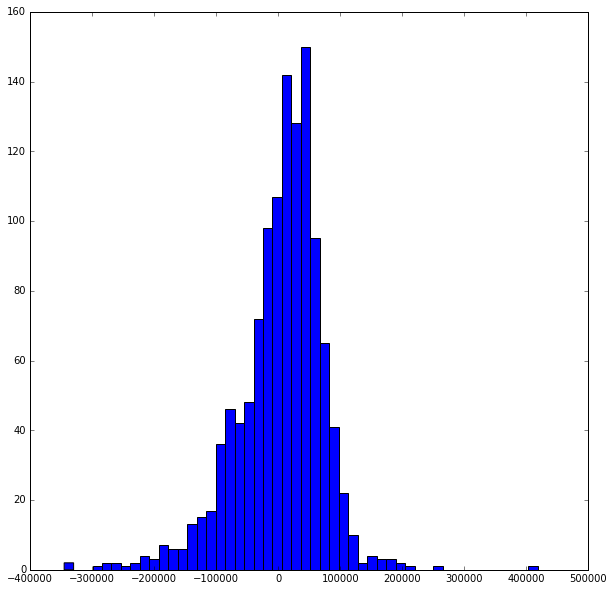

In [4]:
residuals = np.dot(y_validate, classifier.omega) - houseData['Yvalidate']
plt.figure(figsize=(10,10))
plt.hist(residuals, 50)

It resembles a normal distribution.

## Gradient derivation of logistic regression

\begin{align*}
R[w] &= \sum_{i=1}^{n}log(1 + e^{-z^{(i)}}) = \sum_{i=1}^{n}log(\frac{e^{z^{(i)}} + 1}{e^{z^{(i)}}}) \\
&= \sum_{i=1}^{n}log(e^{z^{(i)}} + 1) - z^{(i)} \\
\nabla R[w] &= \frac{\partial}{\partial w_{j}}(\sum_{i=1}^{n}log(e^{z^{(i)}} + 1) - z^{(i)}) \\
&= \sum_{i=1}^{n}\frac{y^{(i)}x_{j}^{(i)}e^{z^{(i)}}}{1 + e^{z^{(i)}}} - y^{(i)}x_{j}^{(i)} \\
&= \sum_{i=1}^{n}y^{(i)}x_{j}^{(i)}(\frac{e^{z^{(i)}}}{1 + e^{z^{(i)}}} - 1) = \sum_{i=1}^{n}y^{(i)}x_{j}^{(i)}(\frac{-1}{1 + e^{z^{(i)}}}) \\
&= -Q^{T}Sig(-z) \\
\end{align*}

Where $Q = diag(Y)X$ and $Sig$ is the sigmoid function.

Classify spam data using logistic regression and batch gradient descent. We will pre-process the data 3 different ways and see how this affects the risk.

In [5]:
# load data
spamData = io.loadmat('../data/spam-dataset/spam.mat')
xTrain = spamData['Xtrain']
yTrain = spamData['Ytrain']
print spamData.keys()
xTrain.shape

['__globals__', '__header__', 'Ytrain', 'Xtest', 'Xtrain', '__version__']


(3450, 57)

In [6]:
# pre-processing
# standardize data
stdData = (xTrain - np.mean(xTrain)) / np.std(xTrain)
# taking the log of the data
logData = np.log(xTrain + 0.1)
# making features into binary features
binData = []

for i in range(xTrain.shape[0]):
    rowData = []
    for j in range(xTrain.shape[1]):
        if xTrain[i][j] > 0:
            rowData.append(1)
        else:
            rowData.append(0)
    binData.append(rowData)

binData = np.asarray(binData)

In [7]:
def batch_grad_desc(x, y, eta=0.0001, iters=5000):
    w = np.zeros(x.shape[1])
    y = y.T[0]
    Q = np.dot(np.diag(y), x)
    risk = []
    for i in range(iters):
        z = np.dot(Q, w)
        w += eta * np.dot(Q.T, expit(- z))
        risk.append(sum(np.log(1 + np.exp(- z))))
    return risk
    

### Standardize Data

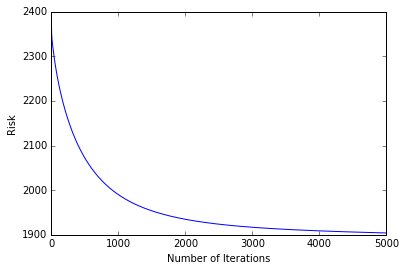

In [8]:
stdRisk = batch_grad_desc(stdData, yTrain, eta=0.00001)
plt.plot(stdRisk)
plt.ylabel('Risk')
plt.xlabel('Number of Iterations')

### Log Data

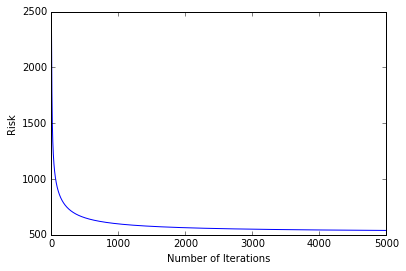

In [9]:
logRisk = batch_grad_desc(logData, yTrain, eta=0.00001)
plt.plot(logRisk)
plt.ylabel('Risk')
plt.xlabel('Number of Iterations')

### Binary Data

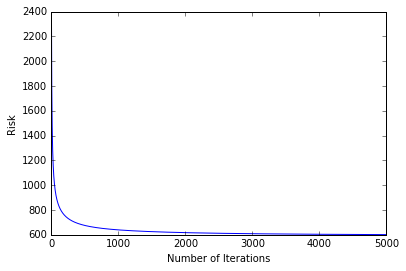

In [10]:
binRisk = batch_grad_desc(binData, yTrain)
plt.plot(binRisk)
plt.ylabel('Risk')
plt.xlabel('Number of Iterations')

We can see that the risk decreases faster with the binarized data.

## Logistic Regression - Stochastic Gradient Descent  Derivation

\begin{align*}
L[w] &= log(1 + e^{-z^{(i)}}) = log(\frac{e^{z^{(i)}} + 1}{e^{z^{(i)}}}) \\
&= log(e^{z^{(i)}} + 1) - z^{(i)} \\
\nabla L[w] &= \frac{\partial}{\partial w_{j}}(log(e^{z^{(i)}} + 1) - z^{(i)}) \\
&= \frac{y^{(i)}x_{j}^{(i)}e^{z^{(i)}}}{1 + e^{z^{(i)}}} - y^{(i)}x_{j}^{(i)} \\
&= y^{(i)}x_{j}^{(i)}(\frac{e^{z^{(i)}}}{1 + e^{z^{(i)}}} - 1) = y^{(i)}x_{j}^{(i)}(\frac{-1}{1 + e^{z^{(i)}}}) \\
&= - y^{(i)}x_{j}^{(i)}Sig(- z^{(i)})
\end{align*}

where $i \in {\{1, 2, 3, ..., n\}}$ is choosen at random.

In [11]:
def stoc_grad_desc(x, y, eta=0.0001, iters=5000):
    n = x.shape[0]
    w = np.zeros(x.shape[1])
    y = y.T[0]
    Q = np.dot(np.diag(y), x)
    risk = []
    for _ in range(iters):
        i = np.random.randint(n)
        z = np.dot(Q, w)
        w += eta * y[i] * x[i] * expit(- z[i])
        risk.append(sum(np.log(1 + np.exp(- z))))
    return risk

### Standardize Data - Stochastic Descent

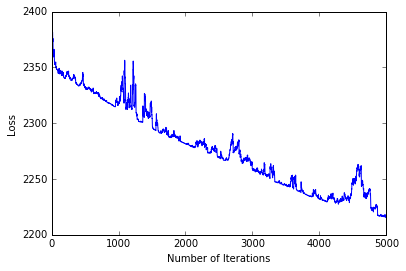

In [12]:
stdLoss = stoc_grad_desc(stdData, yTrain, eta=0.001)
plt.plot(stdLoss)
plt.ylabel('Loss')
plt.xlabel('Number of Iterations')

### Log Data - Stochastic Descent

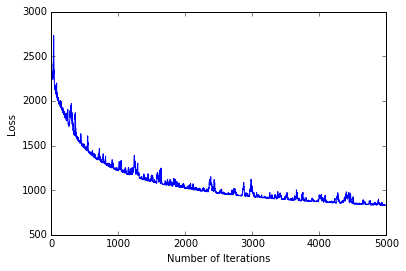

In [13]:
logLoss = stoc_grad_desc(logData, yTrain, eta=0.001)
plt.plot(logLoss)
plt.ylabel('Loss')
plt.xlabel('Number of Iterations')

### Binary Data - Stochastic Descent

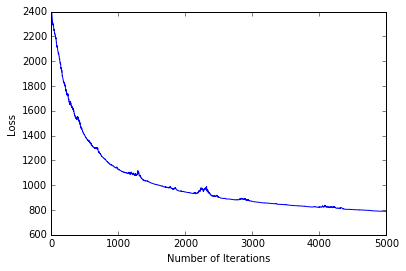

In [14]:
binLoss = stoc_grad_desc(binData, yTrain, eta=0.01)
plt.plot(binLoss)
plt.ylabel('Loss')
plt.xlabel('Number of Iterations')

Difference between batch and stochastic gradient descent: We can see from our plots that although both are decreasing, at some points there are spikes in the loss using stochastic gradient descent, but stochastic descent is faster to compute. When trying to minimize risk/loss, it is easier to get stuck in local minima using batch gradient descent. 